In [29]:
import mofax as mfx
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

sns.set_theme(style="whitegrid")

palette = sns.color_palette("Set2", n_colors=3)

m = mfx.mofa_model("./PDAC_data/mofa_model.hdf5")
print(f"""\
Patients: {m.shape[0]}
Features: {m.shape[1]}
Views: {', '.join(m.views)}"""
)

Patients: 137
Features: 14144
Views: mRNA, Proteome, SCNA


In [30]:
clinical_data = pd.read_csv('./PDAC_data/clinical_data.csv')
clinical_data.drop(["histology_diagnosis", "additiol_pathologic_findings", "cause_of_death"], axis=1, inplace=True)
clinical_data = clinical_data.dropna(subset=['follow_up_days', 'vital_status', 'tumor_stage_pathological'])
clinical_data = clinical_data[['case_id', 'follow_up_days', 'vital_status', 'is_this_patient_lost_to_follow_up']]
clinical_data.index = clinical_data['case_id']  
clinical_data.drop('case_id', axis=1, inplace=True) 

mofa_cases = m.get_samples()['sample']
clinical_samples = clinical_data.index.tolist() 
common_cases = set(clinical_samples) & set(mofa_cases)   

clinical_data = clinical_data.loc[list(common_cases)] 
clinical_data['event'] = clinical_data['vital_status'] == 'Deceased'
clinical_data.head()

,follow_up_days,vital_status,is_this_patient_lost_to_follow_up,event
case_id,,,,
C3N-01716,335.0,Deceased,No,True
C3N-02998,122.0,Deceased,Yes,True
C3L-00640,594.0,Living,No,False
C3N-01011,1068.0,Living,No,False
C3N-03086,733.0,Living,No,False


In [31]:
original_scna_data = pd.read_csv('./PDAC_data/SCNA_gene.csv')
original_scna_data = original_scna_data.T 
original_scna_data.columns = original_scna_data.iloc[0]
original_scna_data = original_scna_data.iloc[1:]
original_scna_data = original_scna_data.loc[list(common_cases)]

Text(0.5, 1.0, 'Correlation of factors')

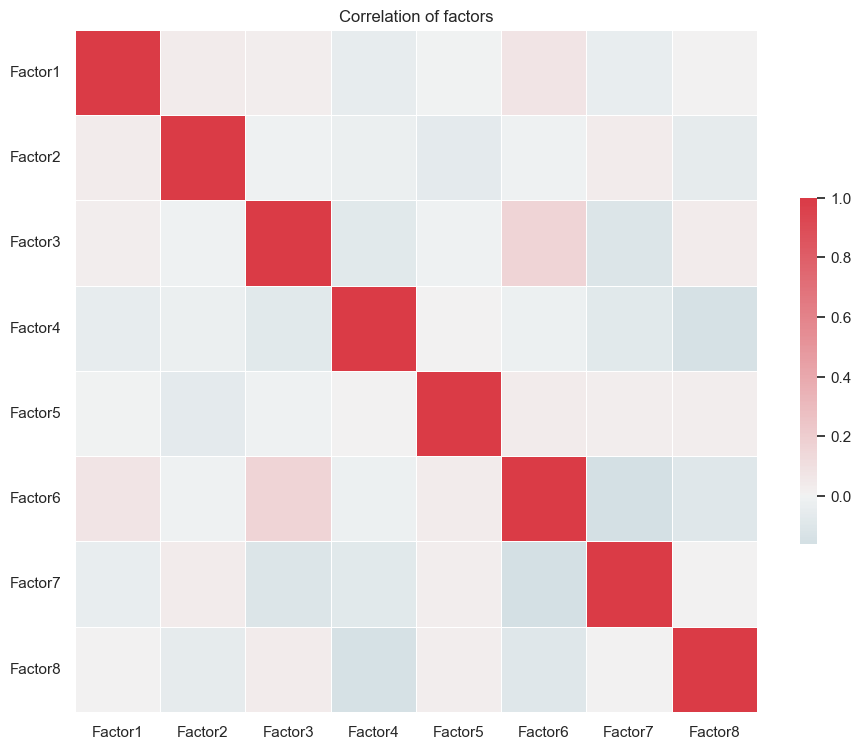

In [32]:
ax = mfx.plot_weights_correlation(m)
ax.set_title("Correlation of factors")

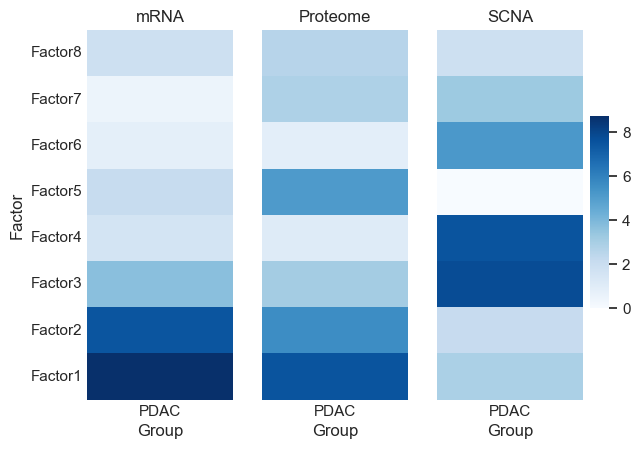

In [33]:
mfx.plot_r2(m)

In [34]:
factors_df = m.get_factors(df=True) 
factors_df = factors_df.loc[list(common_cases)]  

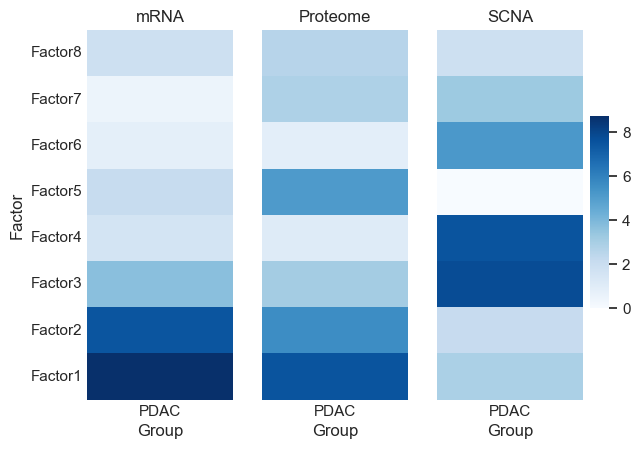

In [35]:
mfx.plot_r2(m)

In [36]:
factor_days_corr = [] 
factor_days_pval = [] 

follow_up_days = clinical_data['follow_up_days'] 

for col in factors_df.columns: 
    corr, pval = stats.spearmanr(factors_df[col], follow_up_days)
    factor_days_corr.append(corr) 
    factor_days_pval.append(pval) 

factor_days_df = pd.DataFrame({
    'Factor': factors_df.columns, 
    'Correlation': factor_days_corr, 
    'P-value': factor_days_pval, 
    'Significant': np.array(factor_days_pval) < 0.05
})

print("Factor-Days Correlations:")
factor_days_df.sort_values('P-value')

Factor-Days Correlations:


,Factor,Correlation,P-value,Significant
3,Factor4,-0.171437,0.053001,False
5,Factor6,0.164344,0.063778,False
1,Factor2,0.110044,0.216255,False
7,Factor8,-0.091548,0.304066,False
0,Factor1,-0.085837,0.335351,False
6,Factor7,-0.063059,0.479481,False
2,Factor3,-0.045185,0.612540,False
4,Factor5,-0.009840,0.912223,False


In [37]:
from lifelines import CoxPHFitter 


cox_results = []

for col in factors_df.columns:
    df = pd.DataFrame({
        'time': clinical_data['follow_up_days'],
        'event': clinical_data['event'],
        'factor': factors_df[col]
    })

    cph = CoxPHFitter()
    cph.fit(
        df, duration_col='time', event_col='event'
    )

    summary = cph.summary.loc['factor']

    cox_results.append({
        'Factor': col,
        'HR': summary['exp(coef)'],
        'Coef': summary['coef'],
        'P-value': summary['p']
    })

cox_df = pd.DataFrame(cox_results).sort_values('P-value')
print(cox_df)
cox_df.to_csv('plots/cox_results.csv')


    Factor        HR      Coef   P-value
1  Factor2  0.753896 -0.282500  0.002358
7  Factor8  1.529151  0.424712  0.016868
3  Factor4  1.263506  0.233890  0.022660
5  Factor6  0.831411 -0.184631  0.208350
2  Factor3  1.021573  0.021344  0.804748
6  Factor7  1.025310  0.024995  0.858935
0  Factor1  1.006422  0.006402  0.915671
4  Factor5  1.006285  0.006265  0.957607


/var/folders/5r/57mydkhj2rn5sflrzbpvr9kw0000gq/T/ipykernel_21589/3967957073.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5r/57mydkhj2rn5sflrzbpvr9kw0000gq/T/ipykernel_21589/3967957073.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette=palette, ax=axes[1])


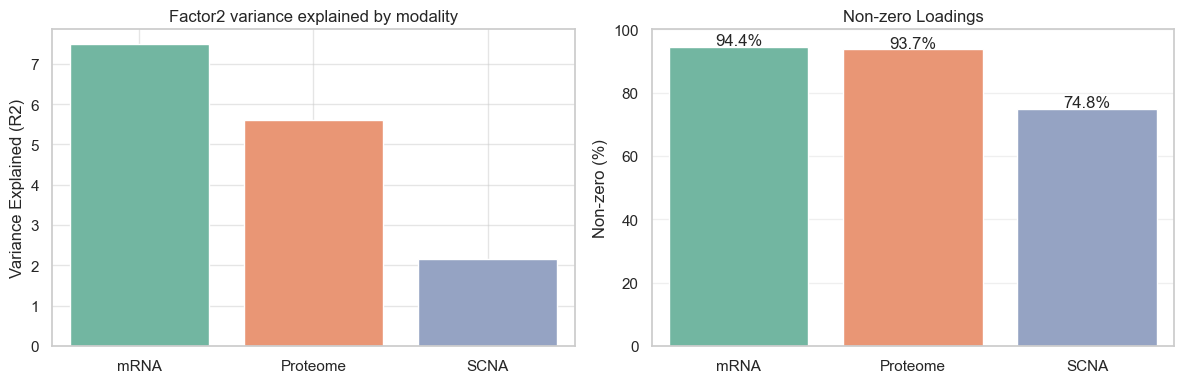

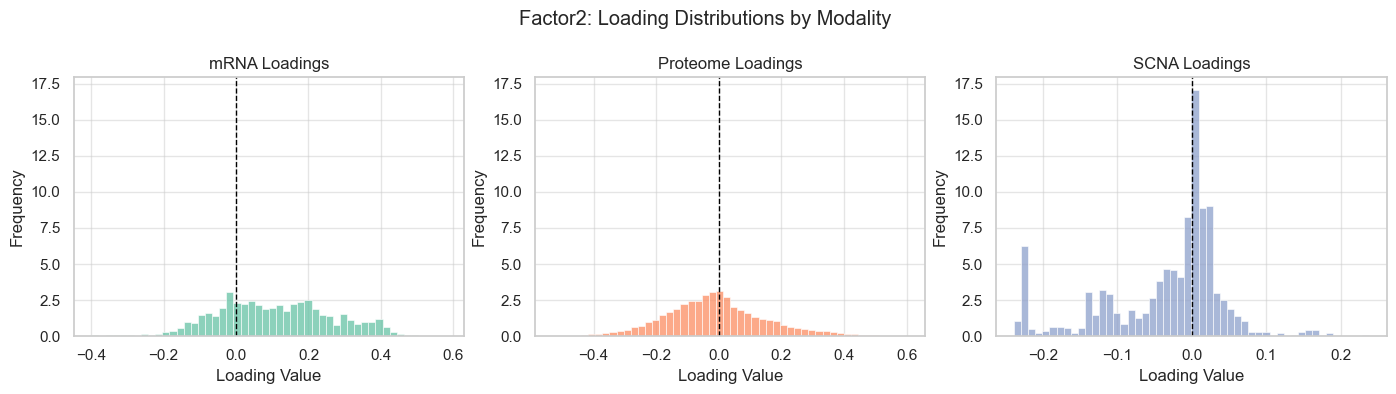

In [38]:
factor = 'Factor2'

r2 = m.get_variance_explained(
    factors=[factor],
    groups=None,
    views=None,
)

weights_df = m.get_weights(df=True)

mrna_weights = weights_df.loc[weights_df.index.str.startswith('mrna_'), factor]
proteome_weights = weights_df.loc[weights_df.index.str.startswith('proteome_'), factor]
scna_weights = weights_df.loc[weights_df.index.str.startswith('scna_'), factor]

threshold = 0.01
labels = ['mRNA', 'Proteome', 'SCNA']
counts = [
    (mrna_weights.abs() > threshold).sum() / len(mrna_weights) * 100,
    (proteome_weights.abs() > threshold).sum() / len(proteome_weights) * 100,
    (scna_weights.abs() > threshold).sum() / len(scna_weights) * 100,
]
r2 = [
    r2[r2['View'] == 'mRNA']['R2'].values[0],
    r2[r2['View'] == 'Proteome']['R2'].values[0],
    r2[r2['View'] == 'SCNA']['R2'].values[0],
]

# Create two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First plot: variance explained (barplot)
sns.barplot(
    x=labels, y=r2, ax=axes[0], palette=palette
)
axes[0].set_title(f"{factor} variance explained by modality")
axes[0].set_ylabel("Variance Explained (R2)")
axes[0].grid(alpha=0.5)

# Second plot: nonzero loadings
sns.barplot(x=labels, y=counts, palette=palette, ax=axes[1])
axes[1].set_ylabel('Non-zero (%)')
axes[1].set_title('Non-zero Loadings')
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', alpha=0.3)
for i, count in enumerate(counts):
    axes[1].text(i, count + 2, f"{count:.1f}%", ha='center', va='center')

plt.tight_layout()
fig.savefig('plots/factor2_modality_variance_and_nonzero.png', dpi=150)
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

hist0, bins0 = np.histogram(mrna_weights, bins=50, density=True)
hist1, bins1 = np.histogram(proteome_weights, bins=50, density=True)
hist2, bins2 = np.histogram(scna_weights, bins=50, density=True)
ymax = max(hist0.max(), hist1.max(), hist2.max())
ymin = 0  

sns.histplot(mrna_weights, bins=50, color=palette[0], ax=axes[0], stat='density')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('mRNA Loadings')
axes[0].set_xlabel('Loading Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.5)
axes[0].set_ylim(ymin, ymax * 1.05)

sns.histplot(proteome_weights, bins=50, color=palette[1], ax=axes[1], stat='density')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Proteome Loadings')
axes[1].set_xlabel('Loading Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.5)
axes[1].set_ylim(ymin, ymax * 1.05)

sns.histplot(scna_weights, bins=50, color=palette[2], edgecolor='white', ax=axes[2], stat='density')
axes[2].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[2].set_title('SCNA Loadings')
axes[2].set_xlabel('Loading Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(alpha=0.5)
axes[2].set_ylim(ymin, ymax * 1.05)

plt.suptitle(f'{factor}: Loading Distributions by Modality')
plt.tight_layout()
fig.savefig('plots/factor2_loading_distributions.png', dpi=150)
plt.show()


In [39]:
factor_name = 'Factor2'

scna_weights_factor = weights_df[weights_df.index.str.startswith('scna_')][factor_name]
weight_threshold = scna_weights_factor.quantile(0.05)

negative_scna = scna_weights_factor[scna_weights_factor < weight_threshold].sort_values()
negative_scna.index = negative_scna.index.str.replace('scna_', '')

print(f"Found {len(negative_scna)} genes with negative loadings")
print(f"Range: {negative_scna.min():.3f} to {negative_scna.max():.3f}")

import mygene
mg = mygene.MyGeneInfo()

gene_list = list(negative_scna.index)
results = mg.querymany(
    gene_list, 
    scopes='symbol', 
    fields='genomic_pos,symbol', 
    species='human', 
    as_dataframe=True
)

results['weight'] = negative_scna 
results = results[['symbol', 'weight', 'genomic_pos.chr', 'genomic_pos.start']]
results.dropna(inplace=True)

results['genomic_pos.chr'].value_counts()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Found 149 genes with negative loadings
Range: -0.239 to -0.223


8 input query terms found no hit:	['TTC25', 'AC099811.2', 'NCBP2-AS2', 'IQCG', 'TCTEX1D2', 'TM4SF19-TCTEX1D2', 'AC069257.3', 'AC068631


genomic_pos.chr
3     61
17    46
Name: count, dtype: int64

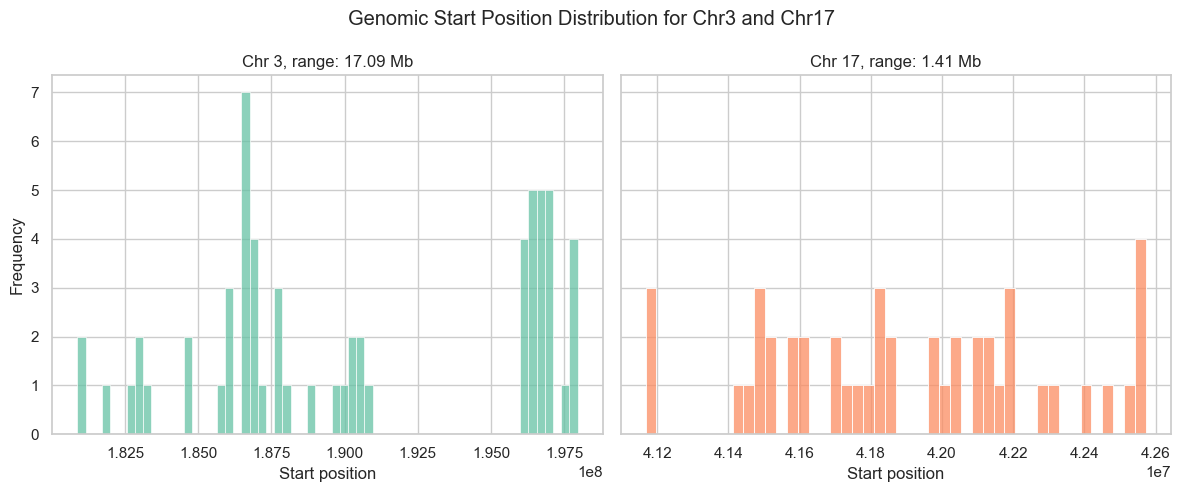

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

chr3 = results[results['genomic_pos.chr'] == '3']
range = chr3['genomic_pos.start'].max() - chr3['genomic_pos.start'].min()
range_mb = (range / 10**6).round(2)

sns.histplot(chr3['genomic_pos.start'], bins=len(chr3), color=palette[0], ax=axes[0])
axes[0].set_title(f'Chr 3, range: {range_mb} Mb')
axes[0].set_xlabel('Start position')
axes[0].set_ylabel('Frequency')

chr17 = results[results['genomic_pos.chr'] == '17']
range = chr17['genomic_pos.start'].max() - chr17['genomic_pos.start'].min()   
range_mb = (range / 10**6).round(2)
sns.histplot(chr17['genomic_pos.start'], bins=len(chr17), color=palette[-2], ax=axes[1])
axes[1].set_title(f'Chr 17, range: {range_mb} Mb')
axes[1].set_xlabel('Start position')

fig.suptitle('Genomic Start Position Distribution for Chr3 and Chr17')
plt.tight_layout()
fig.savefig('plots/chr3_chr17_genomic_startpos_distribution.png', dpi=150)
plt.show()

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

hypothesis_region_ch3 = chr3['genomic_pos.start'].min(), chr3['genomic_pos.start'].max()
genes_in_hypothesis_region_ch3 = results[
    (results['genomic_pos.chr'] == '3') &
    (results['genomic_pos.start'] >= hypothesis_region_ch3[0]) &
    (results['genomic_pos.start'] <= hypothesis_region_ch3[1])
]
sns.histplot(genes_in_hypothesis_region_ch3['weight'], ax=axes[0], color=palette[0])
axes[0].set_title('Chr 3: Weights in Hypothesis Region')

hypothesis_region_ch17 = chr17['genomic_pos.start'].min(), chr17['genomic_pos.start'].max()
genes_in_hypothesis_region_ch17 = results[
    (results['genomic_pos.chr'] == '17') &
    (results['genomic_pos.start'] >= hypothesis_region_ch17[0]) &
    (results['genomic_pos.start'] <= hypothesis_region_ch17[1])
]
sns.histplot(genes_in_hypothesis_region_ch17['weight'], ax=axes[1], color=palette[-2])
axes[1].set_title('Chr 17: Weights in Hypothesis Region')

for ax in axes:
    ax.set_xlabel('Weight')
    ax.set_ylabel('Count')

plt.tight_layout()
fig.savefig('plots/chr3_chr17_weight_distribution_in_hypothesis_region.png', dpi=150)
plt.close(fig)

In [13]:
chr3_genes = chr3.index.tolist() 
ch3_data = original_scna_data.loc[:, chr3_genes]

ch17_genes = chr17.index.tolist() 
ch17_data = original_scna_data.loc[:, ch17_genes]

chr3_avg = ch3_data.mean(axis=1)
chr17_avg = ch17_data.mean(axis=1) 

spearman_corr, spearman_p = stats.spearmanr(chr3_avg, chr17_avg)
print(f"Spearman between Chr3 and Chr17 means: {spearman_corr:.4f} (p={spearman_p:.4g})")

survival_time_corr3 = stats.spearmanr(clinical_data['follow_up_days'], chr3_avg) 
survival_time_corr17 = stats.spearmanr(clinical_data['follow_up_days'], chr17_avg)  

print(f"Spearman between Chr3 and survival time: {survival_time_corr3[0]:.4f} (p={survival_time_corr3[1]:.4g})")
print(f"Spearman between Chr17 and survival time: {survival_time_corr17[0]:.4f} (p={survival_time_corr17[1]:.4g})")

factor_corr_3 = stats.spearmanr(factors_df['Factor2'], chr3_avg) 
factor_corr_17 = stats.spearmanr(factors_df['Factor2'], chr17_avg)  

print(f"Spearman between Factor2 and Chr3: {factor_corr_3[0]:.4f} (p={factor_corr_3[1]:.4g})")
print(f"Spearman between Factor2 and Chr17: {factor_corr_17[0]:.4f} (p={factor_corr_17[1]:.4g})")

Spearman between Chr3 and Chr17 means: 0.3230 (p=0.0002007)
Spearman between Chr3 and survival time: -0.0679 (p=0.4463)
Spearman between Chr17 and survival time: -0.1810 (p=0.04086)
Spearman between Factor2 and Chr3: -0.2304 (p=0.008877)
Spearman between Factor2 and Chr17: -0.2960 (p=0.000693)


In [14]:
from gprofiler import GProfiler 

top_negative_mrna = mrna_weights.sort_values(ascending=True).head(100).index
top_negative_mrna = [mrna.replace('mrna_', '') for mrna in top_negative_mrna]
all_genes = [gene.replace('mrna_', '') for gene in mrna_weights.index]

gp = GProfiler(return_dataframe=True)

res = gp.profile(
    organism="hsapiens",
    query=top_negative_mrna,
    background=all_genes,
    sources=["GO:BP", "REAC", "KEGG", "HALLMARK"],
    combined=False
)
res = res[res['p_value'] < 0.05][['source', 'name', 'p_value', 'intersection_size']]
res

,source,name,p_value,intersection_size
0,GO:BP,cytokine-mediated signaling pathway,0.000128,16
1,KEGG,Cytokine-cytokine receptor interaction,0.000237,14
2,KEGG,Viral protein interaction with cytokine and cytokine receptor,0.003449,10
3,GO:BP,cellular response to cytokine stimulus,0.008103,16
4,GO:BP,granulocyte chemotaxis,0.010858,10
5,GO:BP,inflammatory response,0.015952,18
6,GO:BP,leukocyte chemotaxis,0.024014,11
7,GO:BP,myeloid leukocyte migration,0.024014,11
8,GO:BP,response to cytokine,0.028645,16
9,GO:BP,response to peptide,0.045664,16


In [15]:
top_negative_proteome = proteome_weights.sort_values(ascending=True).head(50).index 
top_negative_proteome = [proteome.replace('proteome_', '') for proteome in top_negative_proteome]
all_proteome_genes = [gene.replace('proteome_', '') for gene in proteome_weights.index]

res = gp.profile(
    organism="hsapiens",
    query=top_negative_proteome,
    background=all_proteome_genes,
    sources=["GO:BP", "REAC", "KEGG", "HALLMARK"],
    combined=False
)
res = res[res['p_value'] < 0.05][['source', 'name', 'p_value', 'intersection_size']]
res

,source,name,p_value,intersection_size
0,GO:BP,double-strand break repair via break-induced replication,9.823730e-07,5
1,REAC,Unwinding of DNA,9.096544e-06,5
2,KEGG,DNA replication,4.744610e-05,5
3,GO:BP,regulation of DNA-templated DNA replication initiation,1.266312e-04,5
4,GO:BP,DNA replication initiation,1.656172e-04,6
5,GO:BP,defense response to fungus,2.688609e-04,6
6,GO:BP,response to fungus,1.346474e-03,6
7,REAC,Activation of the pre-replicative complex,4.047180e-03,5
8,REAC,Activation of ATR in response to replication stress,8.069051e-03,5
9,KEGG,Neutrophil extracellular trap formation,8.234258e-03,5


In [42]:
import os

factor = 'Factor8'

# Ensure 'plot' directory exists
os.makedirs('plot', exist_ok=True)

r2 = m.get_variance_explained(
    factors=[factor],
    groups=None,
    views=None,
)

weights_df = m.get_weights(df=True)

mrna_weights = weights_df.loc[weights_df.index.str.startswith('mrna_'), factor]
proteome_weights = weights_df.loc[weights_df.index.str.startswith('proteome_'), factor]
scna_weights = weights_df.loc[weights_df.index.str.startswith('scna_'), factor]

threshold = 0.01
labels = ['mRNA', 'Proteome', 'SCNA']
counts = [
    (mrna_weights.abs() > threshold).sum() / len(mrna_weights) * 100,
    (proteome_weights.abs() > threshold).sum() / len(proteome_weights) * 100,
    (scna_weights.abs() > threshold).sum() / len(scna_weights) * 100,
]
r2_list = [
    r2[r2['View'] == 'mRNA']['R2'].values[0],
    r2[r2['View'] == 'Proteome']['R2'].values[0],
    r2[r2['View'] == 'SCNA']['R2'].values[0],
]

# Plot 1: Variance explained and Non-zero loadings
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    x=labels, y=r2_list, ax=axes1[0], palette=palette
)
axes1[0].set_title(f"{factor} variance explained by modality")
axes1[0].set_ylabel("Variance Explained (R2)")
axes1[0].grid(alpha=0.5)

sns.barplot(x=labels, y=counts, palette=palette, ax=axes1[1])
axes1[1].set_ylabel('Non-zero (%)')
axes1[1].set_title('Non-zero Loadings')
axes1[1].set_ylim(0, 100)
axes1[1].grid(axis='y', alpha=0.3)
for i, count in enumerate(counts):
    axes1[1].text(i, count + 2, f"{count:.1f}%", ha='center', va='center')

plt.tight_layout()
fig1.savefig("plot/factor8_variance_nonzero.png", dpi=150)
plt.close(fig1)

# Plot 2: Loading distributions by modality
fig2, axes2 = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

hist0, bins0 = np.histogram(mrna_weights, bins=50, density=True)
hist1, bins1 = np.histogram(proteome_weights, bins=50, density=True)
hist2, bins2 = np.histogram(scna_weights, bins=50, density=True)
ymax = max(hist0.max(), hist1.max(), hist2.max())
ymin = 0  

sns.histplot(mrna_weights, bins=50, color=palette[0], ax=axes2[0], stat='density')
axes2[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes2[0].set_title('mRNA Loadings')
axes2[0].set_xlabel('Loading Value')
axes2[0].set_ylabel('Frequency')
axes2[0].grid(alpha=0.5)
axes2[0].set_ylim(ymin, ymax * 1.05)

sns.histplot(proteome_weights, bins=50, color=palette[1], ax=axes2[1], stat='density')
axes2[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes2[1].set_title('Proteome Loadings')
axes2[1].set_xlabel('Loading Value')
axes2[1].set_ylabel('Frequency')
axes2[1].grid(alpha=0.5)
axes2[1].set_ylim(ymin, ymax * 1.05)

sns.histplot(scna_weights, bins=50, color=palette[2], edgecolor='white', ax=axes2[2], stat='density')
axes2[2].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes2[2].set_title('SCNA Loadings')
axes2[2].set_xlabel('Loading Value')
axes2[2].set_ylabel('Frequency')
axes2[2].grid(alpha=0.5)
axes2[2].set_ylim(ymin, ymax * 1.05)

plt.suptitle(f'{factor}: Loading Distributions by Modality')
plt.tight_layout()
fig2.savefig("plot/factor8_loading_distributions.png", dpi=150)
plt.close(fig2)

/var/folders/5r/57mydkhj2rn5sflrzbpvr9kw0000gq/T/ipykernel_21589/4245426199.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5r/57mydkhj2rn5sflrzbpvr9kw0000gq/T/ipykernel_21589/4245426199.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette=palette, ax=axes1[1])


In [17]:
factor_name = "Factor8"

scna_weights_factor_8 = weights_df[weights_df.index.str.startswith('scna_')][factor_name]
weight_threshold = scna_weights_factor_8.quantile(0.95)
positive_scna = scna_weights_factor_8[scna_weights_factor_8 > weight_threshold].sort_values()
positive_scna.index = positive_scna.index.str.replace('scna_', '')

print(f"Found {len(positive_scna)} genes with positive loadings")
print(f"Range: {positive_scna.min():.3f} to {positive_scna.max():.3f}")

import mygene
mg = mygene.MyGeneInfo()

gene_list = list(positive_scna.index)
results_positive = mg.querymany(
    gene_list, 
    scopes='symbol', 
    fields='genomic_pos,symbol', 
    species='human', 
    as_dataframe=True
)

results_positive['weight'] = positive_scna 
results_positive = results_positive[['symbol', 'weight', 'genomic_pos.chr', 'genomic_pos.start']]
results_positive.dropna(inplace=True)

results_positive['genomic_pos.chr'].value_counts()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Found 149 genes with positive loadings
Range: 0.357 to 0.535


8 input query terms found no hit:	['TM4SF19-TCTEX1D2', 'AC069257.3', 'TCTEX1D2', 'NCBP2-AS2', 'IQCG', 'AC131160.1', 'AC068631.2', 'HRA


genomic_pos.chr
3    135
Name: count, dtype: int64

In [18]:
weight_threshold = scna_weights_factor_8.quantile(0.05)
negative_scna = scna_weights_factor_8[scna_weights_factor_8 < weight_threshold].sort_values()
negative_scna.index = negative_scna.index.str.replace('scna_', '')

print(f"Found {len(negative_scna)} genes with negative loadings")
print(f"Range: {negative_scna.min():.3f} to {negative_scna.max():.3f}")

import mygene
mg = mygene.MyGeneInfo()

gene_list = list(negative_scna.index)
results_negative = mg.querymany(
    gene_list, 
    scopes='symbol', 
    fields='genomic_pos,symbol', 
    species='human', 
    as_dataframe=True
)

results_negative['weight'] = negative_scna 
results_negative = results_negative[['symbol', 'weight', 'genomic_pos.chr', 'genomic_pos.start']]
results_negative.dropna(inplace=True)

results_negative['genomic_pos.chr'].value_counts()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Found 137 genes with negative loadings
Range: -0.519 to -0.412


1 input query terms found dup hits:	[('KLRC4-KLRK1', 2)]
5 input query terms found no hit:	['AC068775.1', 'AC006518.7', 'AC092111.3', 'HIST4H4', 'H2AFJ']


genomic_pos.chr
12    102
Name: count, dtype: int64

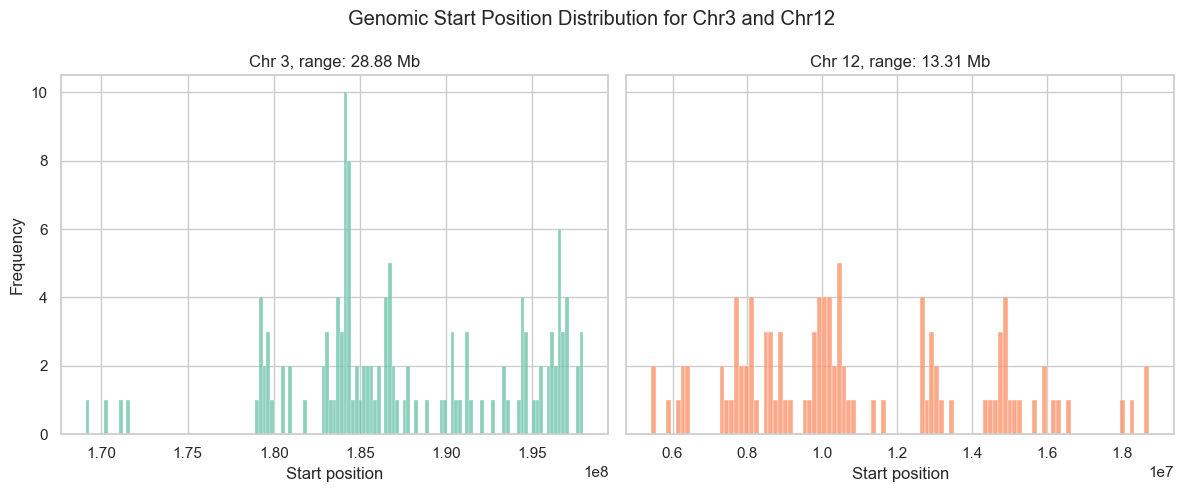

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

chr3 = results_positive[results_positive['genomic_pos.chr'] == '3']
ch12 = results_negative[results_negative['genomic_pos.chr'] == '12']

range3 = chr3['genomic_pos.start'].max() - chr3['genomic_pos.start'].min()
range3_mb = (range3 / 10**6).round(2)

sns.histplot(chr3['genomic_pos.start'], bins=len(chr3), color=palette[0], ax=axes[0])
axes[0].set_title(f'Chr 3, range: {range3_mb} Mb')
axes[0].set_xlabel('Start position')
axes[0].set_ylabel('Frequency')

range12 = ch12['genomic_pos.start'].max() - ch12['genomic_pos.start'].min()
range12_mb = (range12 / 10**6).round(2)

sns.histplot(ch12['genomic_pos.start'], bins=len(ch12), color=palette[-2], ax=axes[1])
axes[1].set_title(f'Chr 12, range: {range12_mb} Mb')
axes[1].set_xlabel('Start position')

fig.suptitle('Genomic Start Position Distribution for Chr3 and Chr12')
plt.tight_layout()
plt.show()

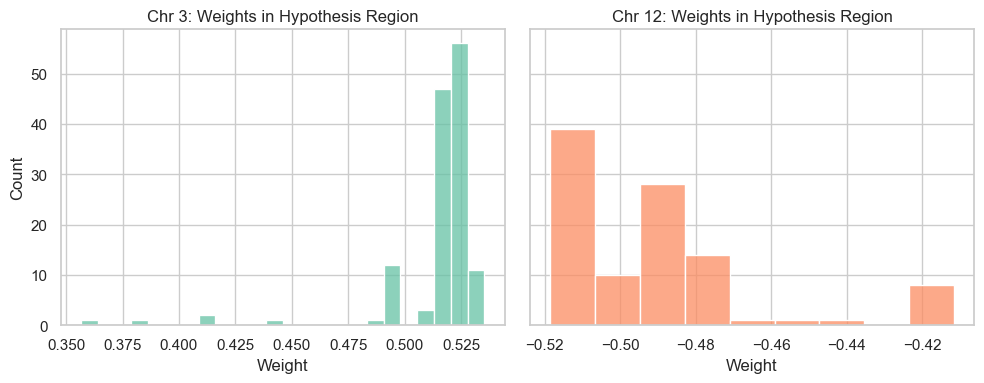

In [20]:
hypothesis_region_ch3 = chr3['genomic_pos.start'].min(), chr3['genomic_pos.start'].max()
hypothesis_region_ch12 = ch12['genomic_pos.start'].min(), ch12['genomic_pos.start'].max()

genes_in_hypothesis_region_ch3 = results_positive[
    (results_positive['genomic_pos.chr'] == '3') &
    (results_positive['genomic_pos.start'] >= hypothesis_region_ch3[0]) &
    (results_positive['genomic_pos.start'] <= hypothesis_region_ch3[1])
]

genes_in_hypothesis_region_ch12 = results_negative[
    (results_negative['genomic_pos.chr'] == '12') &
    (results_negative['genomic_pos.start'] >= hypothesis_region_ch12[0]) &
    (results_negative['genomic_pos.start'] <= hypothesis_region_ch12[1])
]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.histplot(genes_in_hypothesis_region_ch3['weight'], ax=axes[0], color=palette[0])
axes[0].set_title('Chr 3: Weights in Hypothesis Region')

sns.histplot(genes_in_hypothesis_region_ch12['weight'], ax=axes[1], color=palette[-2])
axes[1].set_title('Chr 12: Weights in Hypothesis Region')

for ax in axes:
    ax.set_xlabel('Weight')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [21]:
chr3_genes = chr3.index.tolist() 
ch3_data = original_scna_data.loc[:, chr3_genes]

ch12_genes = ch12.index.tolist() 
ch12_data = original_scna_data.loc[:, ch12_genes]

chr3_avg = ch3_data.mean(axis=1)
chr12_avg = ch12_data.mean(axis=1) 

spearman_corr, spearman_p = stats.spearmanr(chr3_avg, chr12_avg)
print(f"Spearman between Chr3 and Chr12 means: {spearman_corr:.4f} (p={spearman_p:.4g})")

survival_time_corr3 = stats.spearmanr(clinical_data['follow_up_days'], chr3_avg) 
survival_time_corr12 = stats.spearmanr(clinical_data['follow_up_days'], chr12_avg)  

print(f"Spearman between Chr3 and survival: {survival_time_corr3[0]:.4f} (p={survival_time_corr3[1]:.4g})")
print(f"Spearman between Chr12 and survival: {survival_time_corr12[0]:.4f} (p={survival_time_corr12[1]:.4g})")

factor_corr_3 = stats.spearmanr(factors_df['Factor8'], chr3_avg) 
factor_corr_12 = stats.spearmanr(factors_df['Factor8'], chr12_avg)  

print(f"Spearman between Factor8 and Chr3: {factor_corr_3[0]:.4f} (p={factor_corr_3[1]:.4g})")
print(f"Spearman between Factor8 and Chr12: {factor_corr_12[0]:.4f} (p={factor_corr_12[1]:.4g})")

Spearman between Chr3 and Chr12 means: 0.3000 (p=0.0005821)
Spearman between Chr3 and survival: -0.0674 (p=0.4495)
Spearman between Chr12 and survival: -0.0277 (p=0.7564)
Spearman between Factor8 and Chr3: 0.2734 (p=0.001796)
Spearman between Factor8 and Chr12: -0.0556 (p=0.5331)


In [22]:
top_positive_mrna = mrna_weights.sort_values(ascending=False).head(500).index
top_positive_mrna = [mrna.replace('mrna_', '') for mrna in top_positive_mrna]
all_genes = [gene.replace('mrna_', '') for gene in mrna_weights.index]

top_positive_proteome = proteome_weights.sort_values(ascending=False).head(300).index 
top_positive_proteome = [proteome.replace('proteome_', '') for proteome in top_positive_proteome]
all_proteome_genes = [gene.replace('proteome_', '') for gene in proteome_weights.index]

In [23]:
from gprofiler import GProfiler 

gp = GProfiler(return_dataframe=True)

res = gp.profile(
    organism="hsapiens",
    query=top_positive_mrna,
    background=all_genes,
    sources=["GO:BP", "REAC", "KEGG", "HALLMARK"],
    combined=False
)
res = res[res['p_value'] < 0.05][['source', 'name', 'p_value', 'intersection_size']]
res

,source,name,p_value,intersection_size
0,GO:BP,epidermis development,0.021918,34
1,GO:BP,skin development,0.023084,28


In [24]:
from gprofiler import GProfiler 

gp = GProfiler(return_dataframe=True)

res = gp.profile(
    organism="hsapiens",
    query=top_positive_proteome,
    background=all_proteome_genes,
    sources=["GO:BP", "REAC", "KEGG", "HALLMARK"],
    combined=False
)
res = res[res['p_value'] < 0.05][['source', 'name', 'p_value', 'intersection_size']]
res.head(20)

,source,name,p_value,intersection_size
0,GO:BP,collagen fibril organization,2.256032e-08,17
1,REAC,Collagen biosynthesis and modifying enzymes,5.737756e-06,13
2,REAC,Collagen formation,9.090081e-06,15
3,GO:BP,extracellular matrix organization,1.290085e-03,24
4,GO:BP,extracellular structure organization,1.290085e-03,24
5,GO:BP,external encapsulating structure organization,1.290085e-03,24
6,REAC,Extracellular matrix organization,4.073363e-02,22
